In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
from sklearn.cluster import DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"
from GeoRefTool import *
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def count(TSAv):
    temp_count = 0
    apear_ind = []
    counts = []
    for i in range(len(TSAv)):
        if (TSAv[i] == True):
            temp_count += 1
        else:
            if (i > 0) & (TSAv[i - 1] == True):
                apear_ind.append(i - temp_count)
                counts.append(temp_count)
                temp_count = 0
                counts.append(0)
            else:
                counts.append(0)
        if (i == len(TSAv) - 1) & (temp_count != 0):
            apear_ind.append(i - temp_count + 1)
            counts.append(temp_count)
    counts = np.array(counts)
    counts = counts[counts > 0]
    return np.array(counts), np.array(apear_ind)

In [3]:
def gen_xyz(dis,i,j):
    longitudes = theta[i]*np.pi / 180
    latitudes = azimuths[j] * np.pi / 180 
    hypotenuses = dis * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = dis * np.sin(longitudes)
    return np.array([X,Y,Z])

In [22]:
db = Raster_DBSCAN(window_size=[5,13],eps = 1.5,min_samples = 12,Td_map_szie = [32,1800])
dbscan = DBSCAN(eps = 1, min_samples = 20)

In [23]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\2022-1-21-21-30-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)
thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.08,bck_n = 3 )
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 1.5).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:21<00:00,  2.56s/it]


In [28]:
np.random.choice(np.arange(len(aggregated_map)),2000)

array([ 9010, 10662, 10879, ...,  4245,  5717, 17298])

In [ ]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\2022-1-21-21-30-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
selected_inds = np.random.choice(np.arange(len(aggregated_map)),2000)
selected_maps = aggregated_map[selected_inds]


In [30]:
selected_inds = np.random.choice(np.arange(len(aggregated_map)),2000)

aggregated_map[selected_inds]

(2000, 32, 1800)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(points_temp[:,0],points_temp[:,1],s = 3,c = occupancies_temp)
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()

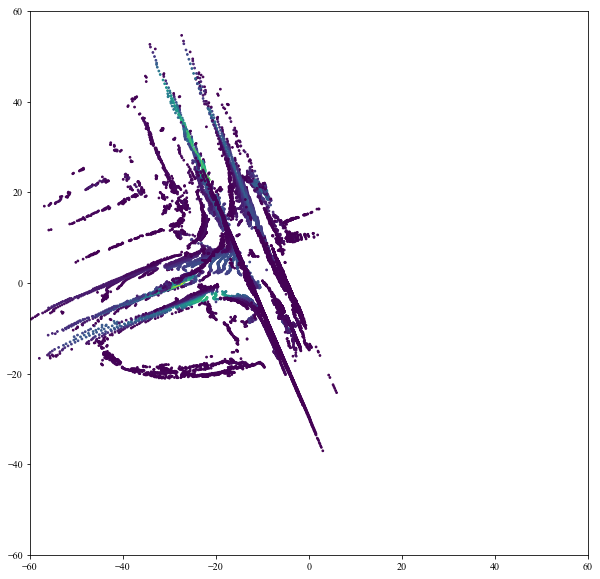

In [70]:
plt.figure(figsize=(10,10))
plt.scatter(points_temp[:,0],points_temp[:,1],s = 3,c = occupancies_temp)
plt.ylim(-60,60)
plt.xlim(-60,60)
plt.show()

22.332
1309


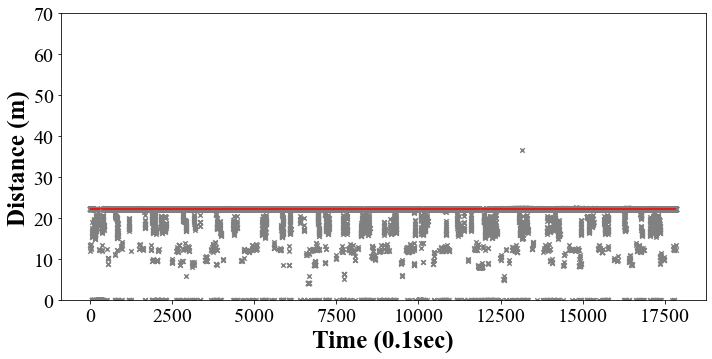

In [93]:
laser_id = 4
azimuth_channel = 1309
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

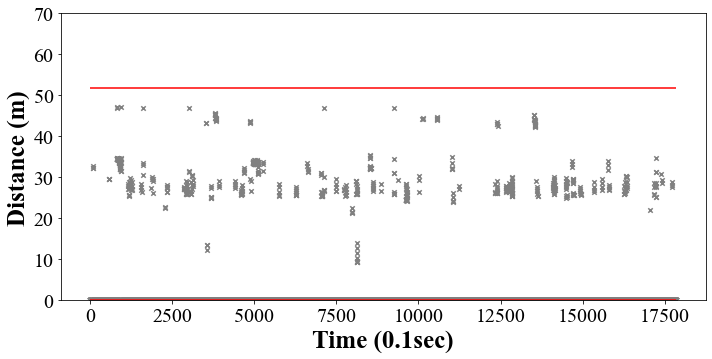

In [21]:
temp = foreground_points
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
# thred = thred_map[:,i,j]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

In [69]:
Moving_map = np.zeros((aggregated_map.shape[1],aggregated_map.shape[2])) #the distance for moving motions
Occupancy_map = np.zeros((aggregated_map.shape[1],aggregated_map.shape[2])) #occupancy in each direction
Volume_map = np.zeros((aggregated_map.shape[1],aggregated_map.shape[2]))

for i in tqdm(range(aggregated_map.shape[1])):
    for j in range(aggregated_map.shape[2]):
        temp = aggregated_map[:,i,j].copy()
        foreground_points = temp.copy()
        thred = thred_map[:,i,j]

        for s in thred:
            d = 0.5
            foreground_points[(foreground_points < (s + d) )&(foreground_points > (s - d))] = 0
        foreground = foreground_points[foreground_points != 0]
        
        if len(foreground) > 0:
            counts,appear_ind = count(foreground_points != 0)
            volume = len(counts)
            occupancy = (foreground_points != 0).sum() / len(foreground_points)
            Moving_map[i,j] = np.median(foreground)
            Occupancy_map[i,j] = occupancy
            Volume_map[i,j] = volume * 2 # veh/h
        

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [31:12<00:00, 58.50s/it]


In [70]:
pcd = get_pcd_uncolored(Moving_map)
points = np.asarray(pcd.points)

In [138]:
index = ~(points == 0).all(axis = 1)

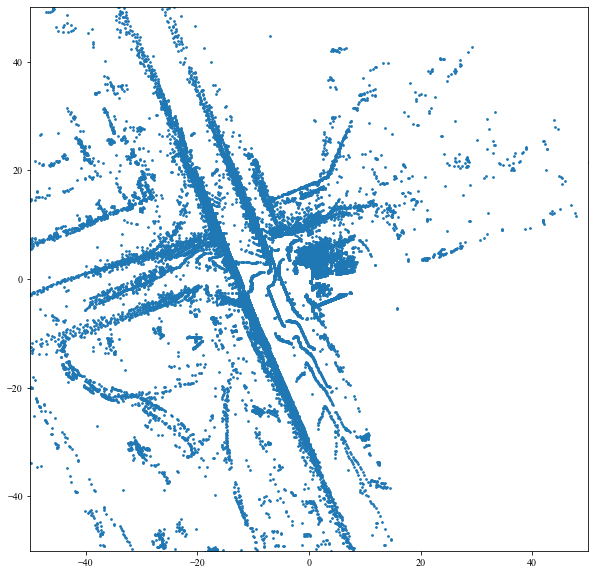

In [140]:
pcd = get_pcd_uncolored(Moving_map)
points = np.asarray(pcd.points)
plt.figure(figsize=(10,10))
plt.scatter(points[:,0][index],points[:,1][index],s = 3)
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()

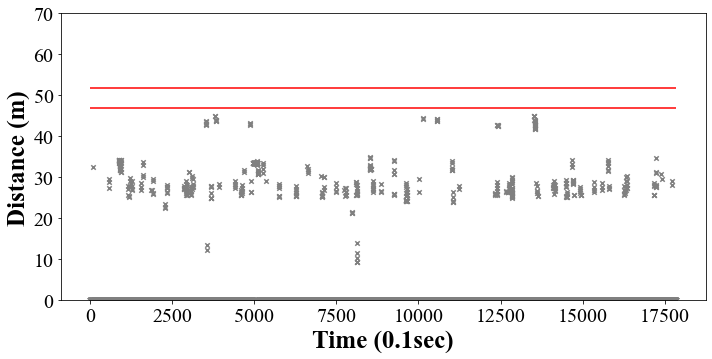

In [47]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(foreground_points)),foreground_points,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)

# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()